(sec:structopt-methods)=
# Optimization methods

The first class of special points on the PES that we will discuss are local energy minima. These correspond to equilibrium molecular structures and are characterized by a vanishing first order energy derivative combined with a Hessian matrix which has only positive eigenvalues. The procedure to determine a local minimum (i.e. finding the coordinates that minimize the energy) is called a structure optimization.  

```{figure} ../../img/pes/PES.png
:scale: 100%
```
In practical terms, the ingredients to perform a geometry optimization include: (1) the initial molecular coordinates, (2) a choice of coordinate system, (3) the energy at a specific geometry $E(\mathbf{x})$, (4) the gradient $\mathbf{g}(\mathbf{x})=\nabla E(\mathbf{x})$, (5) the Hessian, and (6) a procedure to update the coordinates and Hessian and move on the potential energy surface towards lower energy. 

Having addressed [the issue of coordinate system](coord), the remaining question is what procedure to use to move along the potential energy surface and arrive at a local energy minimum. There are several iterative methods to do this, some of which need only information on the energy gradient (e.g. gradient-descent, conjugate gradient), while others take into account also the Hessian (Newton--Raphson, quasi-Newton). For a detailed review of minimization techniques, see {cite}`Snyman2005`.

## Gradient descent

The simplest optimization procedure is to repeatedly take a step in the direction opposite to the local gradient
%
\begin{equation}
\mathbf{x}_{i+1} = \mathbf{x}_i - k_i\mathbf{g}(\mathbf{x}_i) \nonumber 
\end{equation}
where by $\mathbf{x}_{i+1}$ we denote the new coordinates (in a generic coordinate system -- either Cartesian or internal coordinates), $\mathbf{x}_i$ are the coordinates at the previous step $i$, $\nabla E$ is the energy gradient and $k_i$ is the step size. The step size can either be kept constant, or adjusted at each iteration, e.g. by the line search procedure.

The gradient-descent method is simple to implement and is guaranteed to converge, but has the disadvantage that it requires many steps and becomes slow when close to the minimum where the gradient is small. It always converges to a local minimum, given enough steps.


### Implementation
Let's implement the gradient descent method. We will need to set up a molecule, an SCF driver and a gradient driver.

In [1]:
# Import section
import veloxchem as vlx
import py3Dmol as p3d
from veloxchem.veloxchemlib import bohr_in_angstroms
import numpy as np
from matplotlib import pyplot as plt

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 8.


In [2]:
# Define the molecule
molecule_xyz = """3
water
  O 0.000 0.000  0.000
  H 0.000 0.000  0.950
  H 0.896 0.000 -0.317
"""
molecule = vlx.Molecule.from_xyz_string(molecule_xyz)

# and basis set
basis_set_label = 'sto-3g'
basis = vlx.MolecularBasis.read(molecule, basis_set_label)

* Info * Reading basis set from file: /home/emi/miniconda3/envs/echem/lib/python3.10/site-packages/veloxchem/basis/STO-3G 
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: STO-3G                                                                              
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
                

In [3]:
view = p3d.view(linked=True, viewergrid=(1,1),width=400,height=300)
view.addModel(molecule_xyz, 'xyz', viewer=(0,0))
view.setViewStyle({"style": "outline", "width": 0.05})
view.setStyle({'stick': {}, 'sphere': {'scale':0.25}})
view.rotate(-90, "x")
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [4]:
# SCF Energy
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.conv_thresh = 1.0e-6
# for DFT
# scf_drv.xcfun = "b3lyp"
# scf_drv.grid_level = 4

# Gradient
grad_driver = vlx.ScfGradientDriver(scf_drv=scf_drv)

Now, write your own routine to run one gradient descent iteration:
```python
def gradient_descent_iteration(coordinates, gradient, step):
    ...
    return new_coordinates
```

In [5]:
def gradient_descent_iteration(coordinates, gradient, step):
    new_coordinates = coordinates - step * gradient
    return new_coordinates

And the routine that runs the optimization:
```python
def gradient_descent(molecule, basis, scf_driver, gradient_driver,
                     step=0.1, threshold=1e-3, max_iter=10):

    # set ostream state to False, to avoid printout from every new scf calculation
    ostream_state = scf_driver.ostream.state
    scf_driver.ostream.state = False
    gradient_driver.ostream.state = False
    
    iteration = 0
    grad_norm = 100
    
    # atom labels (symbols)
    labels = molecule.get_labels()
    
    # initial atomc coordinates
    old_coords = molecule.get_coordinates()
    scf_results = scf_driver.compute(molecule, basis, None)
    old_energy = scf_driver.get_scf_energy()
    gradient_driver.compute(molecule, basis)
    old_gradient = gradient_driver.gradient
    
    print("Starting gradient descent:\n")
    text = "Iteration     Energy (H)      "
    text += "Max. displacement (bohr)    Gradient norm (H/bohr)"
    print(text)

    energies = [old_energy]
    iterations = [0]

    while (grad_norm >= threshold) and (iteration <= max_iter):
        ...
        ...
        ...

        
    if iteration <= max_iter:
        text = "\n   *** Gradient Descent converged in "
        text += "%d iteration(s). *** " % iteration
        print(text)
        return new_molecule, iterations, energies
    else:
        print("\n   !!! Gradient Descent did not converge  !!! ")
        return None, None, None

    # Set the ostream state to initial value
    scf_driver.ostream.state = ostream_state
    gradient_driver.ostream.state = ostream_state
```

In [6]:
def gradient_descent(molecule, basis, scf_driver, gradient_driver,
                     step=0.1, threshold=1e-3, max_iter=10):
    # set ostream state to False, to avoid printout from every new scf calculation
    ostream_state = scf_driver.ostream.state
    scf_driver.ostream.state = False
    gradient_driver.ostream.state = False
    
    iteration = 0
    grad_norm = 100
    # atom labels (symbols)
    labels = molecule.get_labels()
    
    # initial atomic coordinates
    old_coords = molecule.get_coordinates()
    
    scf_results = scf_driver.compute(molecule, basis, None)
    old_energy = scf_driver.get_scf_energy()
    
    gradient_driver.compute(molecule, basis)
    old_gradient = gradient_driver.gradient
    
    print("Starting gradient descent:\n")
    text = "Iteration     Energy (H)      "
    text += "Max. displacement (bohr)    Gradient norm (H/bohr)"
    print(text)
    energies = [old_energy]
    iterations = [0]
    while (grad_norm >= threshold) and (iteration <= max_iter):
        coords = gradient_descent_iteration(old_coords, old_gradient, step)
        
        # calculate the energy and gradient corresponding to the new coordinates
        new_molecule = vlx.molecule.Molecule(labels, coords, units='au')
        
        scf_results = scf_driver.compute(new_molecule, basis, None)
        energy = scf_driver.get_scf_energy()
        energies.append(energy)
        
        gradient_driver.compute(new_molecule, basis)
        gradient = gradient_driver.gradient
        grad_norm = np.linalg.norm(gradient)
        
        displacement = old_coords - coords
        max_disp = np.amax(abs(displacement))
        
        # calculate energy difference
        delta_e = abs(energy - old_energy)
        text = "   %3d.  %15.7f      " % (iteration, energy, )
        text += "%15.7f          %15.7f" % (max_disp, grad_norm)
        print(text)
        
        # save 
        old_energy = energy
        old_gradient = gradient
        old_coords = coords
        iteration += 1
        iterations.append(iteration)
        
    if iteration <= max_iter:
        text = "\n   *** Gradient Descent converged in "
        text += "%d iteration(s). *** " % iteration
        print(text)
        return new_molecule, iterations, energies
    else:
        print("\n   !!! Gradient Descent did not converge  !!! ")
        return None, None, None
    scf_driver.ostream.state = ostream_state
    gradient_driver.ostream.state = ostream_state

In [7]:
opt_mol, gd_iterations, gd_energies = gradient_descent(molecule, basis,
                                                       scf_drv, grad_driver,
                                                       threshold=1e-2,
                                                       max_iter=100)

Starting gradient descent:

Iteration     Energy (H)      Max. displacement (bohr)    Gradient norm (H/bohr)
     0.      -74.9605109            0.0071311                0.0994035
     1.      -74.9614427            0.0063668                0.0881487
     2.      -74.9621766            0.0056990                0.0784445
     3.      -74.9627589            0.0051136                0.0700529
     4.      -74.9632239            0.0045989                0.0627797
     5.      -74.9635981            0.0041452                0.0564644
     6.      -74.9639013            0.0037442                0.0509731
     7.      -74.9641488            0.0033892                0.0461931
     8.      -74.9643524            0.0030741                0.0420288
     9.      -74.9645214            0.0027940                0.0383981
    10.      -74.9646627            0.0025445                0.0352305
    11.      -74.9647818            0.0023220                0.0324649
    12.      -74.9648833            0.0

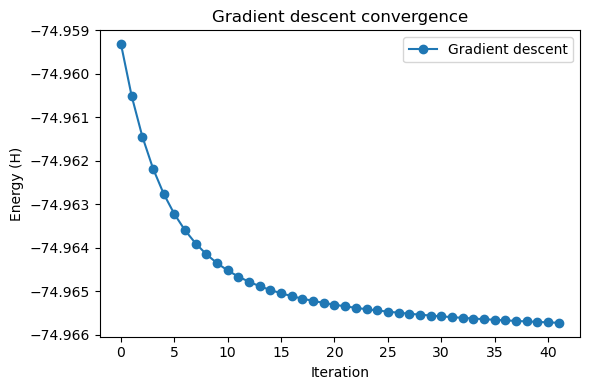

In [8]:
plt.figure(figsize=(6,4))

plt.plot(gd_iterations, gd_energies,'o-', label='Gradient descent')

plt.axis(xmin=-2, xmax=43)

plt.xlabel('Iteration')
plt.ylabel('Energy (H)')
plt.title("Gradient descent convergence")
plt.legend()
plt.tight_layout(); plt.show()

## Conjugate gradient
An improved method over the gradient-descent approach is to use the "gradient history" (steps $i$ and $i-1$) to determine the coordinates at step $i+1$
%
\begin{equation}
    \mathbf{x}_{i+1} = \mathbf{x}_i - k_i \mathbf{h}_i \nonumber
\end{equation}
with $\mathbf{h}_i = \mathbf{g}(\mathbf{x}_i)+\gamma_i\mathbf{h}_{i-1}$. The function $\gamma_i$ contains gradient information from steps $i$ and $i-1$ and can be defined in different ways. For example, in the Fletcher-Reeves conjugate gradient method
%
\begin{equation}
    \gamma_i = \frac{|\mathbf{g}(\mathbf{x}_i)|^2}{|\mathbf{g}(\mathbf{x}_{i-1})|^2} \nonumber
\end{equation}


### Implementation
Implement the conjugate gradient optimization algorithm and compare its performance to the gradient descent method.
```python
def conjugate_gradient_iteration(coordinates, h, step):
    ...
    return new_coordinates
```

In [13]:
def conjugate_gradient_iteration(coordinates, h, step):
    new_coordinates = coordinates - step * h
    return new_coordinates

```python
def conjugate_gradient(molecule, basis, scf_driver, gradient_driver,
                       step=0.1, threshold=1e-3, max_iter=10):
    # set ostream state to False, to avoid printout from every new scf calculation
    ostream_state = scf_driver.ostream.state
    scf_driver.ostream.state = False
    gradient_driver.ostream.state = False
    
    iteration = 0
    grad_norm = 100
    
    # atom labels (symbols)
    labels = molecule.get_labels()
    
    # initial atomc coordinates
    old_coords = molecule.get_coordinates()
    
    scf_results = scf_driver.compute(molecule, basis, None)
    old_energy = scf_driver.get_scf_energy()
    
    gradient_driver.compute(molecule, basis)
    old_gradient = gradient_driver.gradient
    old_h = old_gradient
    
    print("Starting gradient descent:\n")
    text = "Iteration     Energy (H)      Max. displacement (bohr)"
    text += "Gradient norm (H/bohr)      gamma"
    print(text)
    energies = [old_energy]
    iterations = [0]
    while (grad_norm >= threshold) and (iteration <= max_iter):
        
        ...
        ...
        ...
        
        gamma = grad_norm**2 / old_grad_norm**2
        
        text = "   %3d.  %15.7f      " % (iteration, energy)
        text += "%15.7f          %15.7f" % (max_disp, grad_norm)
        text += "         %15.7f" % (gamma)

        h = gradient + gamma * old_h
        
        # save 
        old_energy = energy
        old_gradient = gradient
        old_coords = coords
        old_h = h
        iteration += 1
        iterations.append(iteration)
        
    if iteration <= max_iter:
        text = "\n   *** Conjugate Gradient converged in "
        text += "%d iteration(s). *** " % iteration
        print(text)
        return new_molecule, iterations, energies
    else:
        print("\n   !!! Conjugate Gradient did not converge  !!! ")
        return None, None, None

    # restore ostream state to its original value
    scf_driver.ostream.state = ostream_state
    gradient_driver.ostream.state = ostream_state
```

In [14]:
def conjugate_gradient(molecule, basis, scf_driver, gradient_driver,
                       step=0.1, threshold=1e-3, max_iter=10):
    # set ostream state to False, to avoid printout from every new scf calculation
    ostream_state = scf_driver.ostream.state
    scf_driver.ostream.state = False
    gradient_driver.ostream.state = False
    
    iteration = 0
    grad_norm = 100
    
    # atom labels (symbols)
    labels = molecule.get_labels()
    
    # initial atomc coordinates
    old_coords = molecule.get_coordinates()
    
    scf_results = scf_driver.compute(molecule, basis, None)
    old_energy = scf_driver.get_scf_energy()
    
    gradient_driver.compute(molecule, basis)
    old_gradient = gradient_driver.gradient
    old_h = old_gradient
    
    print("Starting gradient descent:\n")
    text = "Iteration     Energy (H)      Max. displacement (bohr)"
    text += "     Gradient norm (H/bohr)      gamma"
    print(text)
    energies = [old_energy]
    iterations = [0]
    while (grad_norm >= threshold) and (iteration <= max_iter):        
        coords = conjugate_gradient_iteration(old_coords, old_h, step)
        
        # calculate the energy and gradient corresponding to the new coordinates
        new_molecule = vlx.molecule.Molecule(labels, coords, units='au')

        scf_results = scf_driver.compute(new_molecule, basis, None)
        energy = scf_driver.get_scf_energy()

        gradient_driver.compute(new_molecule, basis)
        gradient = gradient_driver.gradient
        grad_norm = np.linalg.norm(gradient)
        old_grad_norm = np.linalg.norm(old_gradient)
        
        displacement = old_coords - coords
        max_disp = np.amax(abs(displacement))
        
        energies.append(energy)
        
        gamma = grad_norm**2 / old_grad_norm**2
        
        text = "   %3d.  %15.7f      " % (iteration, energy)
        text += "%15.7f          %15.7f" % (max_disp, grad_norm)
        text += "         %15.7f" % (gamma)
        print(text)

        h = gradient + gamma * old_h
        
        # save 
        old_energy = energy
        old_gradient = gradient
        old_coords = coords
        old_h = h
        iteration += 1
        iterations.append(iteration)
        
    if iteration <= max_iter:
        text = "\n   *** Conjugate Gradient converged in "
        text += "%d iteration(s). *** " % iteration
        print(text)
        return new_molecule, iterations, energies
    else:
        print("\n   !!! Conjugate Gradient did not converge  !!! ")
        return None, None, None
    scf_driver.ostream.state = ostream_state
    gradient_driver.ostream.state = ostream_state

In [15]:
cg_opt_mol, cg_iterations, cg_energies = conjugate_gradient(molecule, basis,
                                                            scf_drv, grad_driver,
                                                            threshold=1e-2,
                                                            max_iter=50)

Starting gradient descent:

Iteration     Energy (H)      Max. displacement (bohr)     Gradient norm (H/bohr)      gamma
     0.      -74.9605109            0.0071311                0.0994035               0.7806759
     1.      -74.9621708            0.0119338                0.0783209               0.6208010
     2.      -74.9634822            0.0125176                0.0576486               0.5417781
     3.      -74.9642742            0.0106076                0.0418381               0.5267046
     4.      -74.9647155            0.0083648                0.0311623               0.5547716
     5.      -74.9649702            0.0066283                0.0244842               0.6173223
     6.      -74.9651335            0.0054866                0.0206065               0.7083367
     7.      -74.9652543            0.0048212                0.0185662               0.8117767
     8.      -74.9653573            0.0044747                0.0176220               0.9008706
     9.      -74.9654549

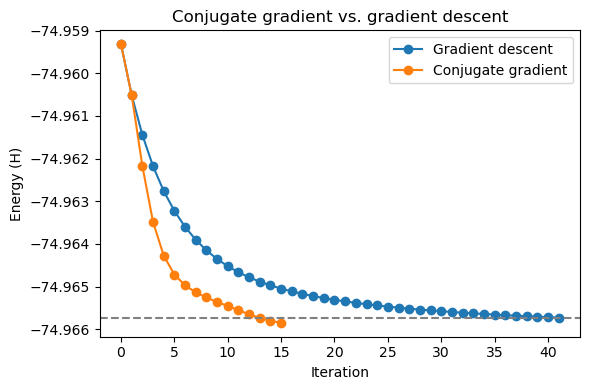

In [16]:
plt.figure(figsize=(6,4))

plt.plot(gd_iterations, gd_energies,'o-', label='Gradient descent')
plt.plot(cg_iterations, cg_energies,'o-', label='Conjugate gradient')

# darw a line which shows the energy obtained using gradient descent 
plt.plot([-2,43], [gd_energies[-1], gd_energies[-1]], '--', color='gray')
plt.axis(xmin=-2, xmax=43)

plt.xlabel('Iteration')
plt.ylabel('Energy (H)')
plt.title("Conjugate gradient vs. gradient descent")
plt.legend()
plt.tight_layout(); plt.show()

## Newton--Raphson and quasi-Newton
The next step in the hierarchy of minimization methods is to use both the first and second order energy derivatives (i.e. gradient $\mathbf{g}$ and Hessian $\mathbf{H}$) in determining the next step in conformation space. This is based on a quadratic approximation for the local shape of the PES
\begin{equation}
    E(\mathbf{x}+\Delta\mathbf{x}) \approx E(\mathbf{x}) + \mathbf{g}(\mathbf{x})\Delta\mathbf{x} + \frac{1}{2}\Delta\mathbf{x}^\mathrm{T}\mathbf{H}\Delta\mathbf{x} \label{eq:quadratic_approx_PES} \nonumber
\end{equation}

Here, $\Delta \mathbf{x}$ is the Newton step used to update the coordinates

\begin{align}
    \Delta \mathbf{x} &= -\mathbf{H}^{-1}\mathbf{g}(\mathbf{x})\label{eq:Newton_step} \nonumber \\
    \mathbf{x}_\mathrm{i+1} &= \mathbf{x}_\mathrm{i}+\Delta \mathbf{x} \nonumber
\end{align}

When redundant internal coordinates are used, it is important to ensure that the displacements are only performed in the non-redundant region of the internal coordinate space. This is achieved by applying a projector $\mathbf{P}=\mathbf{G}^{-}\mathbf{G}$ to the gradient and Hessian before constructing the Newton step {cite}`orcamanual`:
 
 \begin{align}
 \tilde{\mathbf{g}}_q &= \mathbf{P}\mathbf{g}(\mathbf{q}) \, , \nonumber \\
 \tilde{\mathbf{H}}_q &= \mathbf{P}\mathbf{H}_q\mathbf{P}+\alpha(1-\mathbf{P}) \nonumber \,,
 \end{align}

where $\alpha$ is an arbitrary large value (e.g. 1000).
%\textcolor{red}{I haven't perfectly understood what $\alpha$ does yet. The exact quote from the ORCA manual is "The second term for H sets the matrix elements of the redundant part of the internal coordinate space to very large values ($\alpha$ = 1000)"}

As evident from the equations above, the second order derivatives of the energy with respect to nuclear displacements are required to generate the Newton step. The direct computation of these derivatives (which compose the Hessian matrix) is quite expensive, but good _approximations_ for the Hessian can be constructed using the gradient history. For example, the Broyden-Fletcher-Goldfarb-Shanno (BFGS, used by [geomeTRIC](https://github.com/leeping/geomeTRIC)) approach uses the relation:
%
\begin{align}
\mathbf{H}_{i+1} &= \mathbf{H}_i + \frac{\mathbf{h}^{}_i\mathbf{h}_i^\mathrm{T}}{\mathbf{h}_i^\mathrm{T}\mathbf{s}^{}_i} - \frac{\mathbf{H}_i\mathbf{s}_i\left(\mathbf{H}_i\mathbf{s}_i\right)_{}^\mathrm{T}}{\mathbf{s}_i^\mathrm{T}\mathbf{H}_i^{}\mathbf{s}_i^{}} \, ,\nonumber
\end{align}
with,
\begin{align}
\mathbf{h}_i &= \mathbf{g}(\mathbf{x}_{i+1}) - \mathbf{g}(\mathbf{x}_i) \, \nonumber \\
\mathbf{s}_i &= \mathbf{x}_{i+1} - \mathbf{x}_{i} \nonumber \,,
\end{align}
to update the Hessian at step $i+1$ using the Hessian at step $i$ and information about the gradient at the current and previous step.

Quasi-Newton methods, i.e., methods that use approximate Hessians, achieve a very quick convergence at the same computational cost as the gradient-descent method.

```{figure} ../../img/pes/geom_opt_flowchart.png
:scale: 100%
```

### Comparison to gradient descent and conjugate gradient
To compare the gradient descent and conjugate gradient algorithms with the quasi-Newton method, we will use the quasi-Newton implementation from [geomeTRIC](https://github.com/leeping/geomeTRIC).

In [17]:
# Let's run the SCF and gradient again, to make sure we start from the same point:
scf_drv.ostream.state = False
grad_driver.ostream.state = False

scf_drv.compute(molecule, basis)
grad_driver.compute(molecule, basis)

scf_drv.ostream.state = True
grad_driver.ostream.state = True

In [18]:
# Optimization settings and driver:
optimization_settings = {'coordsys' : 'tric'}
# 'tric': TRIC, default
# 'cart': Cartesian
# 'prim': Primitive Internal Coordinates
# 'dlc': Delocalized Internal Coordinates
# 'hdlc': Hybrid Delocalized Internal Coordinates

opt_drv = vlx.OptimizationDriver(grad_driver)
opt_drv.update_settings(opt_dict=optimization_settings)

opt_mol = opt_drv.compute(molecule, basis)

                                                                                                                          
                                                Optimization Driver Setup                                                 
                                                                                                                          
                                     Coordinate System       :    TRIC                                                    
                                     Constraints             :    No                                                      
                                     Max. Number of Steps    :    300                                                     
                                     Transition State        :    No                                                      
                                     Hessian                 :    never                                                   
                

In [19]:
tric_energies = [-74.959319310327, -74.964845254243, -74.965783029341, -74.965900135283]
tric_iterations = [0, 1, 2, 3]

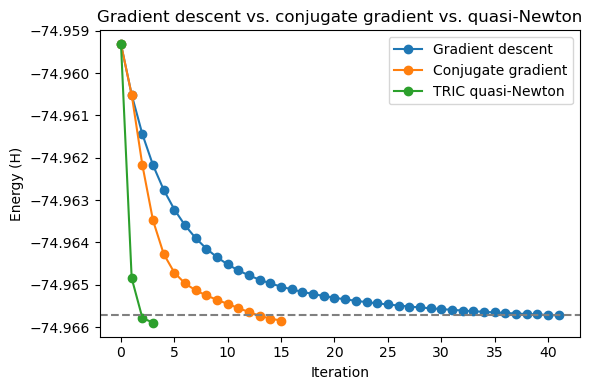

In [21]:
plt.figure(figsize=(6,4))

plt.plot(gd_iterations, gd_energies,'o-', label='Gradient descent')
plt.plot(cg_iterations, cg_energies,'o-', label='Conjugate gradient')
plt.plot(tric_iterations, tric_energies,'o-', label='TRIC quasi-Newton')

# darw a line which shows the energy obtained using gradient descent 
plt.plot([-2,43], [gd_energies[-1], gd_energies[-1]], '--', color='gray')
plt.axis(xmin=-2, xmax=43)

plt.xlabel('Iteration')
plt.ylabel('Energy (H)')
plt.title("Gradient descent vs. conjugate gradient vs. quasi-Newton")
plt.legend()
plt.tight_layout(); plt.show()

```{note}
[GeomeTRIC](https://github.com/leeping/geomeTRIC) offers different options for the type of coordinates used in the optimization: Cartesian, delocalized internal coordinates (DLC), hybrid delocalized internal coordinates (HDLC), as well as translation-rotation internal coordinates (TRIC). How does the choice of coordinates influence the optimization process?
```